In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import matplotlib

matplotlib.rcParams["text.usetex"] = True
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from flipper_training.experiments.ppo.eval import get_eval_rollout, log_from_eval_rollout, PPOExperimentConfig

/Users/davidkorcak/.venv/lib/python3.12/site-packages/torchrl/__init__.py:43: UserWarning: failed to set start method to spawn, and current start method for mp is fork.
  warn(


In [2]:
eval_cfg = "../cross_eval_configs/barrier_easy.yaml"
# eval_cfg = "../final_training_configs/barrier.yaml"

In [3]:
policy_path = "../runs/ppo/final_barrier_thesis_42_2025-05-10_10-46-54/weights/policy_final.pth"

In [4]:
eval_config = OmegaConf.load(eval_cfg)
eval_config["num_robots"] = 16
eval_config["objective_opts"]["cache_size"] = 10
eval_config["max_eval_steps"] = 1000
eval_config["policy_weights_path"] = Path(policy_path)
eval_config["vecnorm_weights_path"] = Path(policy_path.replace("policy", "vecnorm"))
eval_config = PPOExperimentConfig(**eval_config)

In [5]:
env, rollout = get_eval_rollout(eval_config)

2025-05-18 19:59:28,683 [RobotModelConfig][INFO]: Loading robot model from cache: /Users/davidkorcak/Documents/ctu/bachelors/flipper_training/.robot_cache/marv_vx0.010_dp384_b512_whl0.02_trck0.05_eaecc2d5466de1eb8911703837d75c759b5c075158ced88ea318e932700dabb2 (robot_config.py:155)
Init barrier start/goal cache: 100%|██████████| 16/16 [00:00<00:00, 238.34it/s]
2025-05-18 19:59:28,778 [environment][INFO]: Environment: Compiling engine with options {'options': {'triton.cudagraphs': True}, 'fullgraph': True} (env.py:130)
2025-05-18 19:59:31,395 [environment][INFO]: Engine compiled successfully, testing correctness with atol=0.1, rtol=1e-06 (env.py:144)
2025-05-18 19:59:31,459 [environment][INFO]: Compiled engine passed correctness test (env.py:151)
2025-05-18 19:59:33,094 [environment][INFO]: Compiled engine takes 1.634214625 ms per step (env.py:157)


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │             BarrierCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-18 19:59:35,361 [torchrl][INFO] check_env_specs succeeded!
2025-05-18 19:59:35,380 [MLPPolicyConfig][INFO]: Applied orthogonal initialization to the actor and value operators. (mlp_policy.py:89)
2025-05-18 19:59:35,386 [MLPPolicyConfig][INFO]: Loaded weights from ../runs/ppo/final_barrier_thesis_42_2025-05-10_10-46-54/weights/policy_final.pth (mlp_policy.py:94)


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

/Users/davidkorcak/.venv/lib/python3.12/site-packages/torchrl/envs/transforms/transforms.py:6500: UserWarning: VecNorm wasn't initialized and the tensordict is not shared. In single process settings, this is ok, but if you need to share the statistics between workers this should require some attention. Make sure that the content of VecNorm is transmitted to the workers after calling load_state_dict and not before, as other workers may not have access to the loaded TensorDict.
  warnings.warn(


In [6]:
log_from_eval_rollout(rollout)["eval/pct_succeeded"]

1.0

In [7]:
terrain_cfg = env.terrain_cfg

In [8]:
trajectories = rollout["next", "curr_state"]["x"]
trajectories

tensor[16, 261, 3] n=12528 (49Kb) x∈[-1.782, 1.686] μ=-0.002 σ=0.715

In [9]:
z_normalized = terrain_cfg.z_grid / terrain_cfg.z_grid.max()

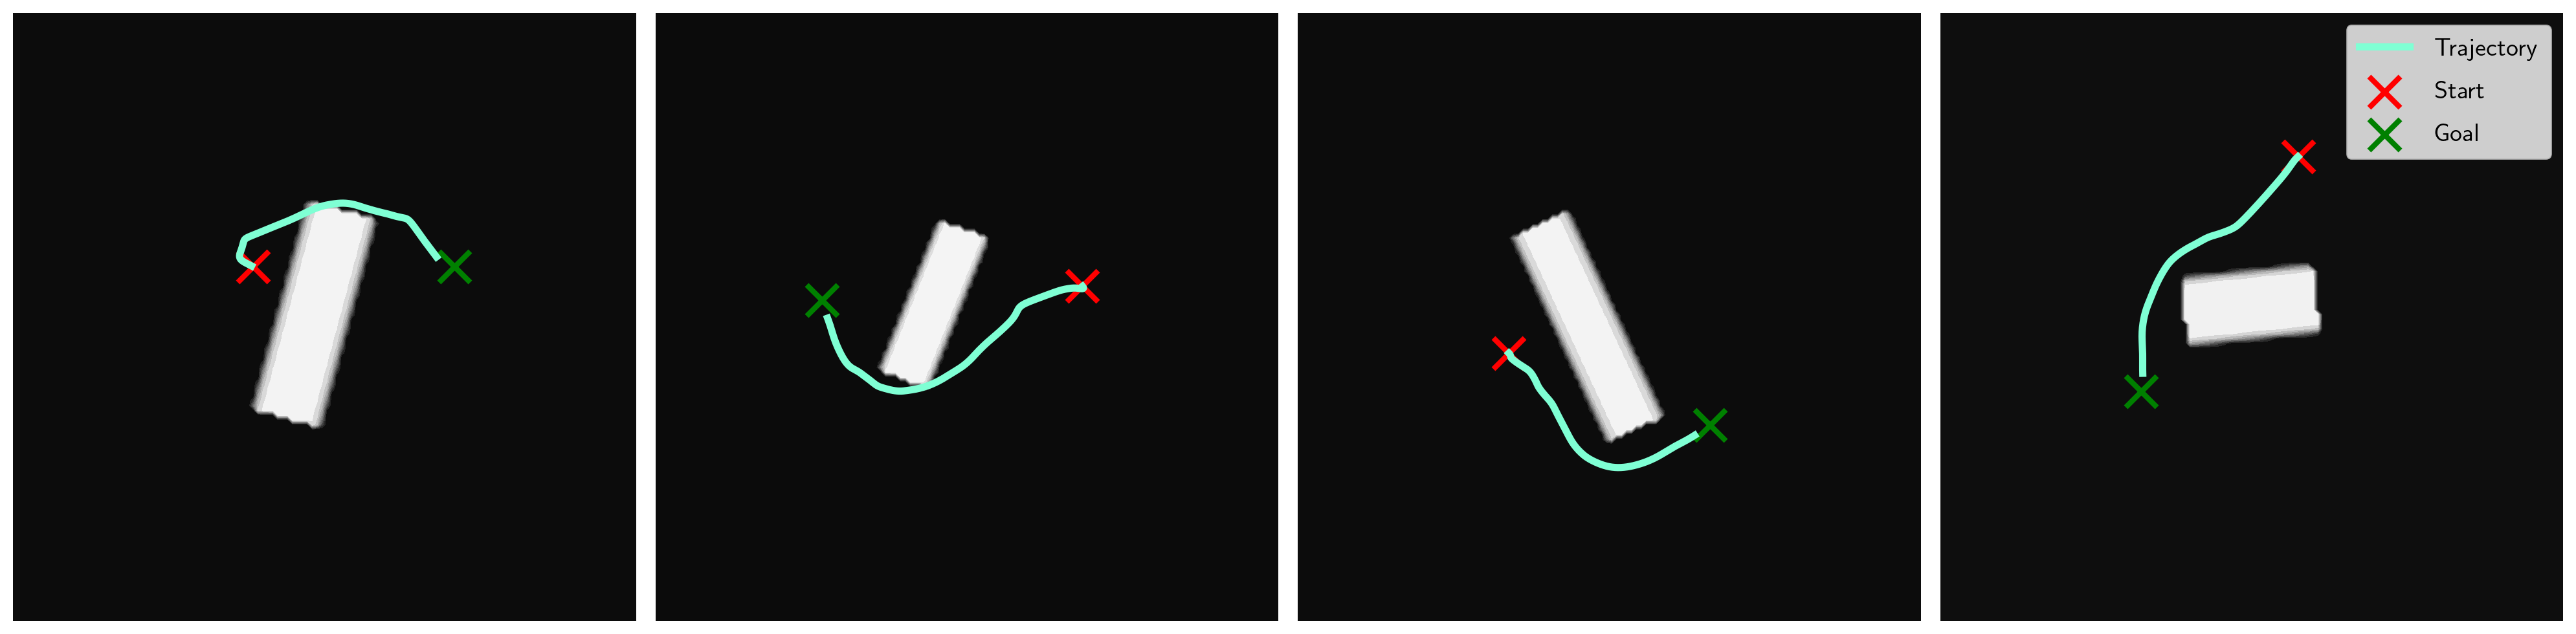

In [16]:
col = 4
row = 1
single_size = 5
fig, ax = plt.subplots(row, col, figsize=(col * single_size, row * single_size), dpi=200)
if ax.ndim == 1:
    ax = ax.reshape(1, -1)
for i in range(min(trajectories.shape[0], row * col)):
    row_idx = i // col
    col_idx = i % col
    start_pos = env.start[i].x
    goal_pos = env.goal[i].x
    ax[row_idx, col_idx].grid(False)
    ax[row_idx, col_idx].axis("off")
    ax[row_idx, col_idx].contourf(
        terrain_cfg.x_grid[i],
        terrain_cfg.y_grid[i],
        z_normalized[i],
        cmap="gray",
        levels=10,
    )
    done_i = rollout["next", "done"][i]
    not_done = ~done_i
    traj_i = trajectories[i, not_done.squeeze(), :2]
    ax[row_idx, col_idx].plot(
        traj_i[:, 0],
        traj_i[:, 1],
        color="aquamarine",
        linewidth=4,
        label="Trajectory",
    )
    ax[row_idx, col_idx].scatter(
        start_pos[None, 0],
        start_pos[None, 1],
        color="red",
        marker="x",
        s=300,
        label="Start",
        lw=3,
    )
    ax[row_idx, col_idx].scatter(
        goal_pos[None, 0],
        goal_pos[None, 1],
        color="green",
        marker="x",
        s=300,
        label="Goal",
        lw=3,
    )
    fig.tight_layout()

ax[0, -1].legend(
    fontsize=14,
    loc="upper right",
    borderpad=0.5,  # padding around the legend
    labelspacing=0.8,  # vertical space between entries
    handletextpad=1.0,  # space between handle and text
)

In [17]:
fig.savefig("/Users/davidkorcak/Documents/ctu/bachelors/bachelor_thesis/figures/barrier_easy_degenerate.pdf")